In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from skimage.color import rgb2lab,lab2rgb
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

In [2]:
def load_data(path):
    Input,Output,images=[],[],[]
    for i in tqdm(os.listdir(path)):
        path_=os.path.join(path,i)
        image=load_img(path_,target_size=(256,256),color_mode='rgb')
        image=img_to_array(image)
        image=image/255.0
        lab=rgb2lab(image)
        Input.append(lab[:,:,0])
        Output.append(lab[:,:,1:]/128)
    return np.array(Input),np.array(Output)

In [3]:
Input,Output=load_data('dataset_2/data/train_color')

  0%|          | 0/5002 [00:00<?, ?it/s]

100%|██████████| 5002/5002 [03:02<00:00, 27.44it/s]


In [4]:
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5002, 256, 256)
Output shape is  (5002, 256, 256, 2)


In [5]:
Input=np.expand_dims(Input,axis=-1)
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5002, 256, 256, 1)
Output shape is  (5002, 256, 256, 2)


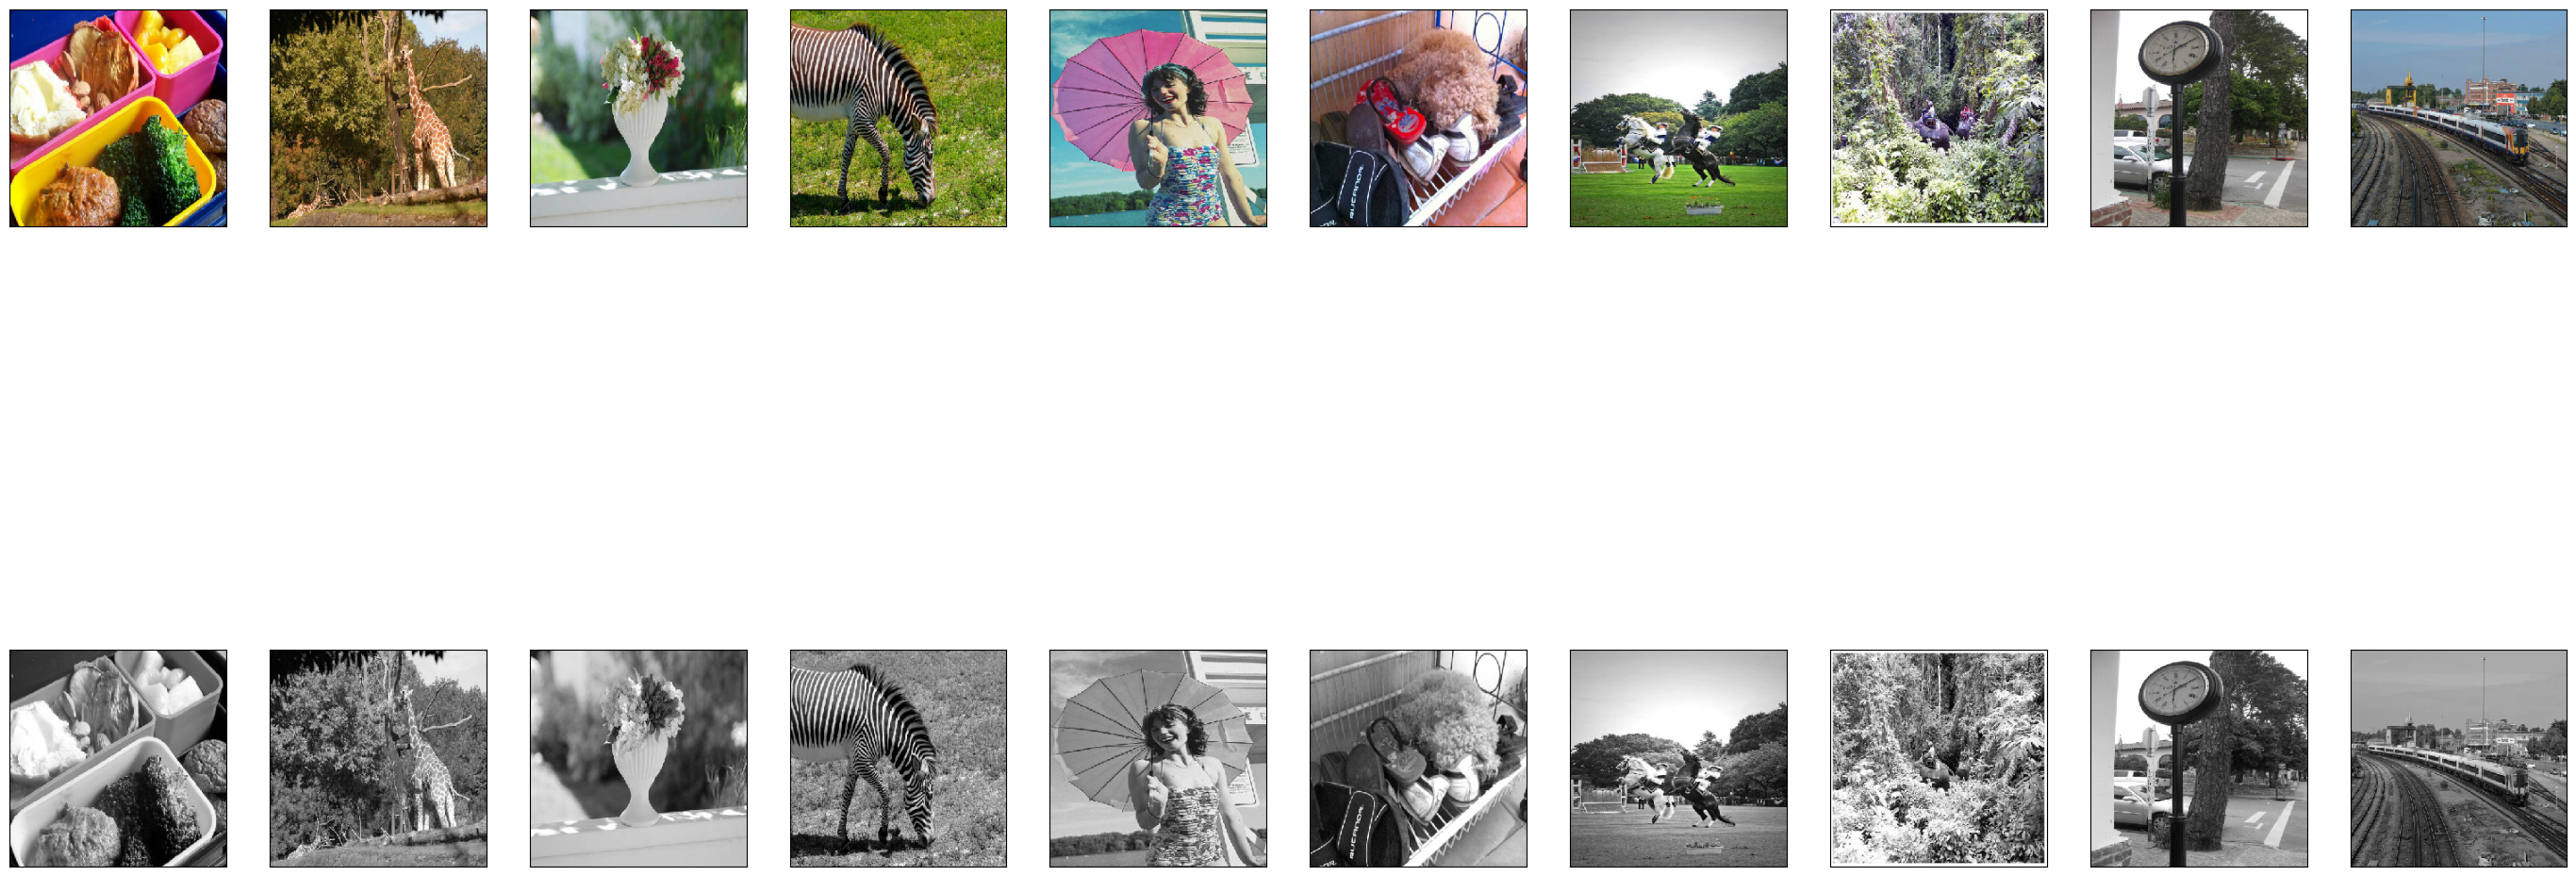

In [6]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    image=np.zeros((256,256,3))
    image[:,:,0]=Input[i][:,:,0]
    image[:,:,1:]=Output[i]*128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(Input[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Input,Output, test_size=0.2, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4001, 256, 256, 1)
X_test shape is  (1001, 256, 256, 1)
y_train shape is  (4001, 256, 256, 2)
y_test shape is  (1001, 256, 256, 2)


In [8]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(256,256,1))
# Encoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',strides=2)(input_)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

# Decoder
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
# Adjust the output layer for an RGB image (2 channels)
x = keras.layers.Conv2D(2, (3, 3), padding='same', activation=keras.layers.LeakyReLU(alpha=.5))(x)
decoder = keras.layers.UpSampling2D((2, 2))(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       118016

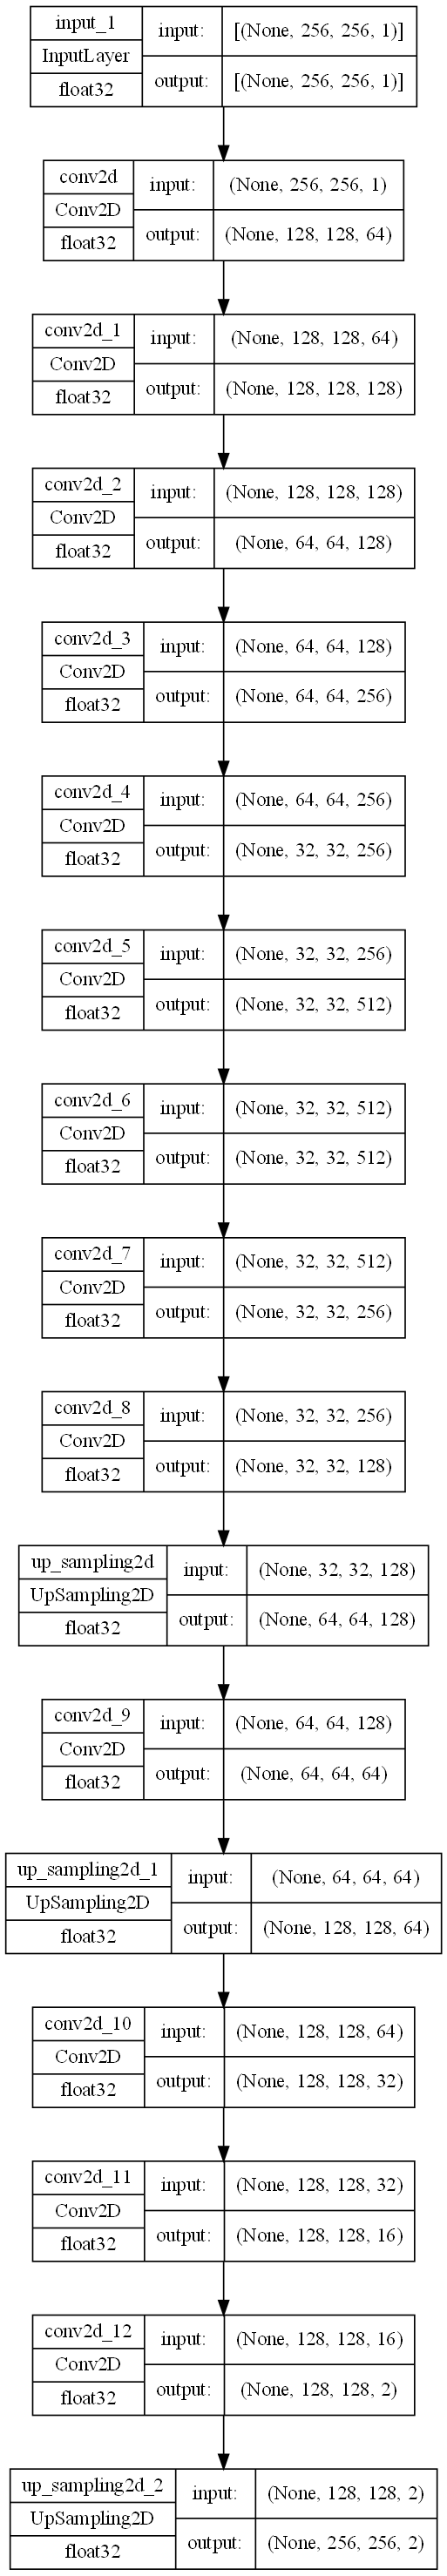

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("autoencoder.h5",save_best_only=True)



with tf.device('/CPU:0'):  # Specifies that TensorFlow should use the CPU
    # Define, compile, and train your model here
    autoencoder.compile(optimizer='adam', loss='mse')
    hist = autoencoder.fit(X_train, y_train, epochs=75, validation_split=0.1, callbacks=[checkpoint_cb])


In [11]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,val_loss
0,0.668949,0.012333
1,0.013171,0.012357
2,0.013154,0.012345
3,0.013065,0.012188
4,0.013004,0.012133
...,...,...
70,0.003163,0.013118
71,0.003117,0.012805
72,0.003077,0.013089
73,0.003041,0.013447


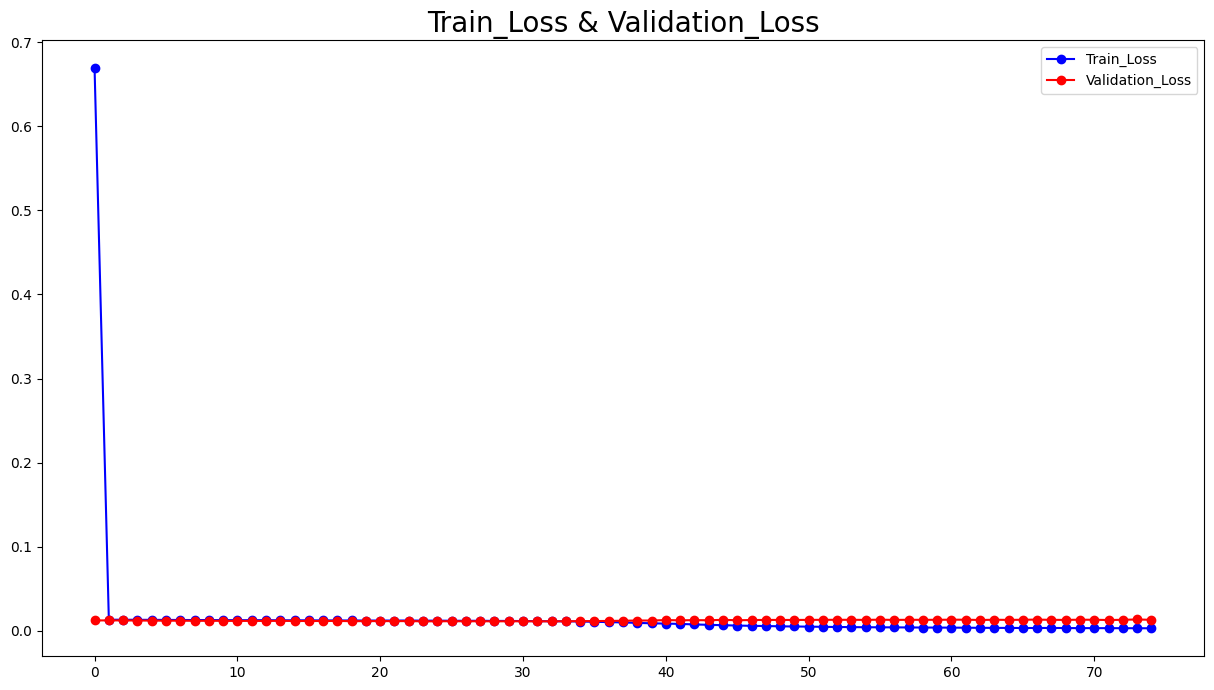

In [12]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [14]:
def predict_generator(data, batch_size=8):
    for i in range(0, len(data), batch_size):
        yield autoencoder.predict(data[i:i+batch_size])

# Example usage:
predictions = np.vstack([batch for batch in predict_generator(X_test, batch_size=8)])


1/1 [==============================] - 0s 20ms/step


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import lab2rgb

n = 10
plt.figure(figsize=(35, 25))
for i in range(n):
    # Display original gray images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i][:, :, 0], cmap='gray')  # Assuming X_test[i] has an L channel in the last dimension
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display original color images
    ax = plt.subplot(3, n, n + i + 1)
    image = np.zeros((256, 256, 3))
    image[:, :, 0] = X_test[i][:, :, 0]  # L channel
    image[:, :, 1:] = y_test[i] * 128  # Scale A and B channels back
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display predicted color images
    ax = plt.subplot(3, n, 2 * n + i + 1)
    image = np.zeros((256, 256, 3))
    image[:, :, 0] = X_test[i][:, :, 0]  # L channel
    image[:, :, 1:] = predictions[i] * 128  # Scale predicted A and B channels back
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [16]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(y_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))

Average PSNR = 15.919717275431164


In [2]:
def predict_and_save_images(input_dir, output_dir, range_spec='all'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # List all files in the input directory
    files = os.listdir(input_dir)
    
    # If a range is specified, filter files based on this range
    if isinstance(range_spec, list) and len(range_spec) == 2:
        files = files[range_spec[0]:range_spec[1]]

    # Process each file
    for filename in files:
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        # Load the image as grayscale (only L channel in LAB)
        image = load_img(input_path, target_size=(256, 256), color_mode='rgb')
        image = img_to_array(image)
        image = image / 255.0
        lab_image = rgb2lab(image)
        L = lab_image[:, :, 0]  # Only L channel
        L = np.expand_dims(L, axis=-1)  # Expand dims to fit model input shape
        L = np.expand_dims(L, axis=0)  # Add batch dimension

        # Predict the AB channels using the autoencoder
        AB = autoencoder.predict(L) * 128  # Scale the outputs back to [-128, 128] range
        
        # Combine L and predicted AB channels
        predicted_image = np.zeros((256, 256, 3))
        predicted_image[:, :, 0] = lab_image[:, :, 0]  # Use original L
        predicted_image[:, :, 1:] = AB[0]  # Use predicted AB
        predicted_rgb = lab2rgb(predicted_image)  # Convert LAB to RGB
        
        # Save the predicted RGB image
        plt.imsave(output_path, predicted_rgb)



In [3]:
def display_all_image_comparisons(black_dir, color_dir, pred_dir):
    # Get lists of files in each directory
    black_files = set(os.listdir(black_dir))
    color_files = set(os.listdir(color_dir))
    pred_files = set(os.listdir(pred_dir))
    
    # Find common filenames across all directories
    common_files = black_files.intersection(color_files, pred_files)
    num_files = len(common_files)
    
    # Check if there are common files to display
    if num_files == 0:
        print("No common files found across directories.")
        return

    # Setting up the subplot
    fig, axes = plt.subplots(nrows=num_files, ncols=3, figsize=(15, 5 * num_files))
    
    for idx, file in enumerate(sorted(common_files)):
        # File paths
        black_path = os.path.join(black_dir, file)
        color_path = os.path.join(color_dir, file)
        pred_path = os.path.join(pred_dir, file)
        
        # Load images
        img_black = load_img(black_path, target_size=(256, 256))
        img_color = load_img(color_path, target_size=(256, 256))
        img_pred = load_img(pred_path, target_size=(256, 256))
        
        # Handle single subplot row case
        if num_files == 1:
            ax1 = plt.subplot(1, 3, 1)
            ax2 = plt.subplot(1, 3, 2)
            ax3 = plt.subplot(1, 3, 3)
        else:
            ax1 = axes[idx, 0]
            ax2 = axes[idx, 1]
            ax3 = axes[idx, 2]
        
        # Plotting images
        ax1.imshow(img_black)
        ax1.axis('off')
        ax1.set_title('Image B&W' if idx == 0 else "")
        
        ax2.imshow(img_color)
        ax2.axis('off')
        ax2.set_title('Colored Image' if idx == 0 else "")
        
        ax3.imshow(img_pred)
        ax3.axis('off')
        ax3.set_title('Predicted Image' if idx == 0 else "")

    plt.tight_layout()
    plt.show()




In [ ]:
predict_and_save_images('dataset_2/data/pred_black_test', 'dataset_2/data/pred_keras_test', range_spec='all')

In [ ]:
predict_and_save_images('dataset_2/data/pred_black_train', 'dataset_2/data/pred_keras_train', range_spec='all')

In [ ]:
display_all_image_comparisons('dataset_2/data/pred_black_test', 'dataset_2/data/pred_color_test', 'dataset_2/data/pred_keras_test')

In [ ]:
display_all_image_comparisons('dataset_2/data/pred_black_train', 'dataset_2/data/pred_color_train', 'dataset_2/data/pred_keras_train')